In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from shearnet.core.dataset import generate_dataset
from shearnet.core.train import train_model
import jax.random as random
import numpy as np

In [3]:
images, labels = generate_dataset(10000, psf_sigma=0.8)

100%|██████████| 10000/10000 [00:23<00:00, 429.25it/s]


In [5]:
# Train
rng_key = random.PRNGKey(42)
state, train_losses, val_losses = train_model(
    images, labels, rng_key, epochs=50, nn='cnn'
)

Epoch 1/50
Validation Loss: 1.6202e-02
New best validation loss: 1.6202e-02
Epoch 2/50
Validation Loss: 8.8795e-03
New best validation loss: 8.8795e-03
Epoch 3/50
Validation Loss: 1.2038e-02
No improvement in validation loss. Patience: 1/5
Epoch 4/50
Validation Loss: 6.1411e-03
New best validation loss: 6.1411e-03
Epoch 5/50
Validation Loss: 5.3874e-03
New best validation loss: 5.3874e-03
Epoch 6/50
Validation Loss: 4.5279e-03
New best validation loss: 4.5279e-03
Epoch 7/50
Validation Loss: 4.6775e-03
No improvement in validation loss. Patience: 1/5
Epoch 8/50
Validation Loss: 3.1256e-03
New best validation loss: 3.1256e-03
Epoch 9/50
Validation Loss: 2.9959e-03
New best validation loss: 2.9959e-03
Epoch 10/50
Validation Loss: 2.3924e-03
New best validation loss: 2.3924e-03
Epoch 11/50
Validation Loss: 2.9158e-03
No improvement in validation loss. Patience: 1/5
Epoch 12/50
Validation Loss: 2.5972e-03
No improvement in validation loss. Patience: 2/5
Epoch 13/50
Validation Loss: 2.9907e-

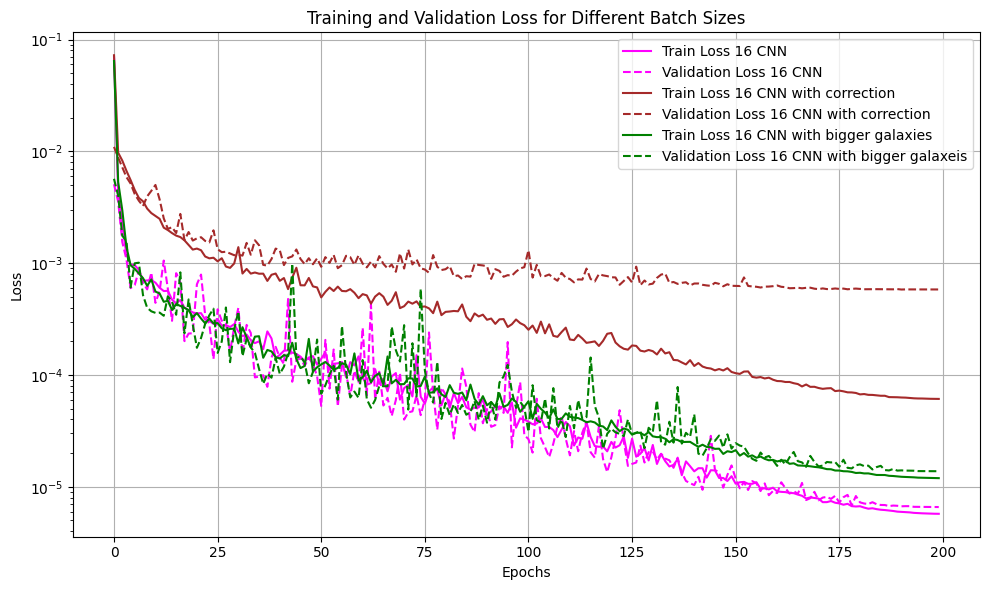

In [5]:
# Load the .npz file
data_cnn1 = np.load('/projects/mccleary_group/saha/codes/.shearnet/plots/cnn5/cnn5_loss.npz')

data_cnn2 = np.load('/projects/mccleary_group/saha/codes/.shearnet/personal/cnn2_loss.npz')
data_cnn3 = np.load('/projects/mccleary_group/saha/codes/.shearnet/personal/cnn3_loss.npz')
# See what arrays are stored in it

train16_cnn2 = data_cnn1['train_loss']
val16_cnn2 = data_cnn1['val_loss']
train16_cnn = data_cnn2['train_loss']
val16_cnn = data_cnn2['val_loss']
train16_cnn1 = data_cnn3['train_loss']
val16_cnn1 = data_cnn3['val_loss']

# Plot the training and validation loss
plt.figure(figsize=(10, 6))
#plt.plot(train256, label='Train Loss 256 MLP', color='blue')
#plt.plot(val256, label='Validation Loss 256 MLP', color='blue', linestyle='--')
#plt.plot(train256_cnn, label='Train Loss 256 CNN', color='cyan')
#plt.plot(val256_cnn, label='Validation Loss 256 CNN', color='cyan', linestyle='--')

#plt.plot(train128, label='Train Loss 128', color='orange')
#plt.plot(val128, label='Validation Loss 128', color='orange', linestyle='--')
#plt.plot(train64, label='Train Loss 64', color='green')
#plt.plot(val64, label='Validation Loss 64', color='green', linestyle='--')
#plt.plot(train32, label='Train Loss 32', color='red')
#plt.plot(val32, label='Validation Loss 32', color='red', linestyle='--')


plt.plot(train16_cnn, label='Train Loss 16 CNN', color='magenta')
plt.plot(val16_cnn, label='Validation Loss 16 CNN', color='magenta', linestyle='--')

plt.plot(train16_cnn1, label='Train Loss 16 CNN with correction', color='brown')
plt.plot(val16_cnn1, label='Validation Loss 16 CNN with correction', color='brown', linestyle='--')

plt.plot(train16_cnn2, label='Train Loss 16 CNN with bigger galaxies', color='green')
plt.plot(val16_cnn2, label='Validation Loss 16 CNN with bigger galaxeis', color='green', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for Different Batch Sizes')
plt.legend()
plt.grid()
plt.yscale('log')
plt.tight_layout()
